<a href="https://colab.research.google.com/github/wikigist/ds_project/blob/main/Predicting_Global_Hits_Using_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libraries

import pandas as pd
import numpy as np
from pandas import Series,DataFrame
from google.cloud import bigquery

In [ ]:
df = pd.read_csv('final_music_data.csv')

In [ ]:
df['global_hit_flag'] = df['global_hit_flag'].replace({'other': 0, 'Global_Hit': 1})

In [ ]:
df.head()

,isrc,master_track,master_artist,sub_genre_name,spotify_streams,tiktok_streams,tiktok_creations,spotify_editorial_streams,youtube_total_streams,amazon_total_streams,...,spotify_streams_percentage,tiktok_streams_percentage,tiktok_creations_percentage,youtube_streams_percentage,amazon_streams_percentage,apple_streams_percentage,domestic_streams,international_streams,home_country_stream_ratio,global_hit_flag
0,AEUM72200038,Baseeb El Donia,Banah,Pop,114185,2502232,2612,60639,13196,56,...,4.333329,94.959889,0.099126,0.500789,0.002125,0.104742,4114,127465,0.031266,0
1,AEUM72000089,El A’ada El Helwa,Banah,Pop,141298,774701,1348,72809,403729,5198,...,10.637667,58.323622,0.101485,30.394872,0.391333,0.151022,4491,548311,0.008124,0
2,AEA2D2200265,Sway My Way,R3HAB,Dance,367002,0,0,120,64546,279,...,82.977309,0.000000,0.000000,14.593526,0.063080,2.366084,0,460135,0.000000,0
3,AEA2D2200224,My Pony,R3HAB,Dance,316138,0,0,13692,301838,4037,...,49.935554,0.000000,0.000000,47.676799,0.637664,1.749983,0,635726,0.000000,0
4,AEA2D2100149,Runaway,R3HAB,Dance,1287431,55,1,2134,496199,3067,...,71.799135,0.003067,0.000056,27.672674,0.171044,0.354024,7,1802898,0.000004,0


In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.dtypes

isrc                                object
master_track                        object
master_artist                       object
sub_genre_name                      object
spotify_streams                      int64
tiktok_streams                       int64
tiktok_creations                     int64
spotify_editorial_streams            int64
youtube_total_streams                int64
amazon_total_streams                 int64
spotify_saves                        int64
isrc_home_country                   object
apple_stream                         int64
total_streams_in_first_30_days       int64
total_streams_in_first_90_days       int64
total_streams_ratio                float64
total_overall_streams                int64
frontline_catalogue                 object
first_stream_date                   object
saves_per_stream                   float64
spotify_editorial_streams_ratio    float64
DSPs_total_streams                   int64
spotify_streams_percentage         float64
tiktok_stre

In [ ]:
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [ ]:
feature_cols = ['total_streams_ratio',
                'saves_per_stream', 
                'spotify_editorial_streams_ratio',
                'spotify_streams_percentage',
                'tiktok_streams_percentage',
                'tiktok_creations_percentage', 
                'youtube_streams_percentage', 
                'amazon_streams_percentage', 
                'apple_streams_percentage', 
                'home_country_stream_ratio']

df["isrc_home_country"] = df["isrc_home_country"].astype('category')
df["frontline_catalogue"] = df["frontline_catalogue"].astype('category')
df["sub_genre_name"] = df["sub_genre_name"].astype('category')

# Convert categorical features to integer codes
df["isrc_home_country"] = df["isrc_home_country"].cat.codes
df["frontline_catalogue"] = df["frontline_catalogue"].cat.codes
df["sub_genre_name"] = df["sub_genre_name"].cat.codes

X = df[feature_cols]
y = df.global_hit_flag

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.30, random_state=42, stratify=y_train
)

cat = [0, 1, 2]  # Use the integer codes for categorical features

train_set = lgbm.Dataset(data=X_train, 
                         label=y_train,
                         categorical_feature=cat, 
                         free_raw_data=False)

validation_set = lgbm.Dataset(data=X_validation, 
                         label=y_validation,
                         categorical_feature=cat, 
                         free_raw_data=False)

test_set = lgbm.Dataset(data=X_test, 
                         label=y_test,
                         categorical_feature=cat, 
                         free_raw_data=False)

lgbm_params = {'max_depth': 4, 
               'learning_rate': 0.01, 
               'objective': 'binary', 
               'scale_pos_weight': y_train.value_counts()[0] / y_train.value_counts()[1],
               'boost_from_average': False,
               'feature_fraction' : 0.7,
              }

evaluation_results = {}
model = lgbm.train(train_set=train_set, 
                   params=lgbm_params,
                   num_boost_round=10000,
                   valid_sets=[train_set, validation_set],
                   valid_names=['Train', 'Validate'], 
                   evals_result=evaluation_results,
                   verbose_eval=1,
                   early_stopping_rounds=50,
                   )

y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be 

Streaming output truncated to the last 5000 lines.
[5950]	Train's binary_logloss: 0.115149	Validate's binary_logloss: 0.143456
[5951]	Train's binary_logloss: 0.115134	Validate's binary_logloss: 0.143441
[5952]	Train's binary_logloss: 0.115118	Validate's binary_logloss: 0.143424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5953]	Train's binary_logloss: 0.11511	Validate's binary_logloss: 0.143417
[5954]	Train's binary_logloss: 0.115102	Validate's binary_logloss: 0.143408
[5955]	Train's binary_logloss: 0.115077	Validate's binary_logloss: 0.143393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5956]	Train's binary_logloss: 0.115069	Validate's binary_logloss: 0.143387
[5957]	Train's binary_logloss: 0.115057	Validate's binary_logloss: 0.143379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5958]	Train's binary_logloss: 0.115049	Validate's binary_logloss: 0.143376
[5959]	Train's binary_logloss: 0.115035	V

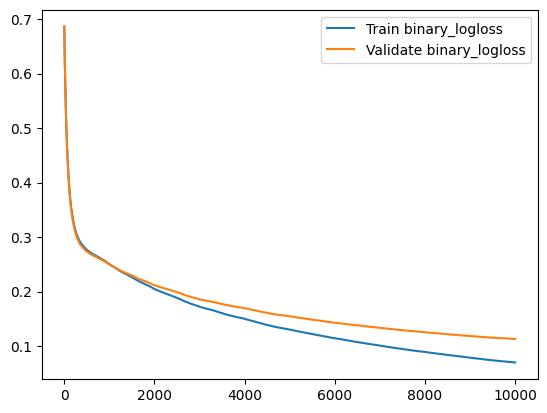

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([index for index in range(len(evaluation_results["Train"]["binary_logloss"]))],
         evaluation_results["Train"]["binary_logloss"], label="Train binary_logloss")
plt.plot([index for index in range(len(evaluation_results["Validate"]["binary_logloss"]))],
         evaluation_results["Validate"]["binary_logloss"], label="Validate binary_logloss")
plt.legend();

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred),
      "\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%",
      "\nPrecision:", round(precision_score(y_test, y_pred) * 100, 2), "%",
      "\nRecall:", round(recall_score(y_test, y_pred) * 100, 2), "%",      
      "\nF1:", round(f1_score(y_test, y_pred) * 100, 2), "%")

Confusion Matrix:
 [[33958  1523]
 [  251   457]] 
Accuracy: 95.1 % 
Precision: 23.08 % 
Recall: 64.55 % 
F1: 34.0 %


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

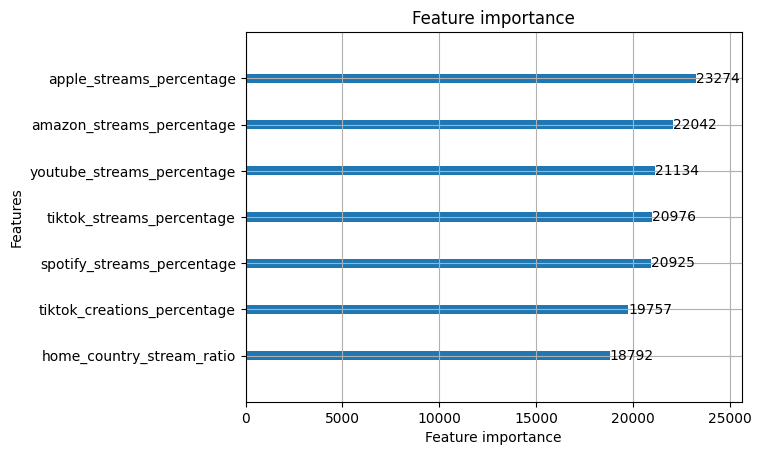

In [ ]:
lgbm.plot_importance(model)

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier


# Create a range of values to test for each hyperparameter
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create the grid search object
rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [ ]:
# Train a Random Forest model with the best hyperparameters
rfc = RandomForestClassifier(n_estimators=150, 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             bootstrap=True)
rfc.fit(X_train, y_train)

# Evaluate the model
y_pred = rfc.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 98.24 %
Confusion Matrix:
 [[35438    43]
 [  594   114]]


In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Create the range of values to test for each hyperparameter
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 6, 9],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0]
}

# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Predict on the test data using the best estimator found by GridSearchCV
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model performance
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred),
      "\nAccuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 9, 'subsample': 1.0}
Confusion Matrix:
 [[35425    56]
 [  586   122]] 
Accuracy: 98.23 %


In [ ]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Normalized confusion matrix
[[0.99842169 0.00157831]
 [0.82768362 0.17231638]]


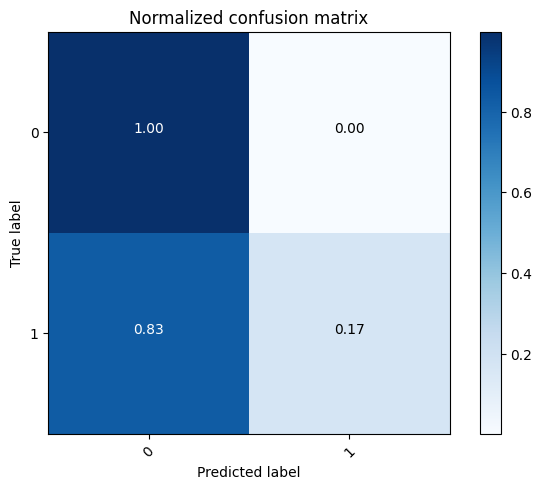

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# generate confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# plot confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')


In [ ]:
import xgboost as xgb

# Create an instance of the XGBClassifier class with the best hyperparameters
xgb_clf = xgb.XGBClassifier(colsample_bytree=0.5, learning_rate=0.1, max_depth=9, subsample=1.0)

# Fit the model to the training data
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_clf.predict(X_test)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     35481
           1       0.69      0.17      0.28       708

    accuracy                           0.98     36189
   macro avg       0.83      0.59      0.63     36189
weighted avg       0.98      0.98      0.98     36189



754/754 [==============================] - 1s 1ms/step


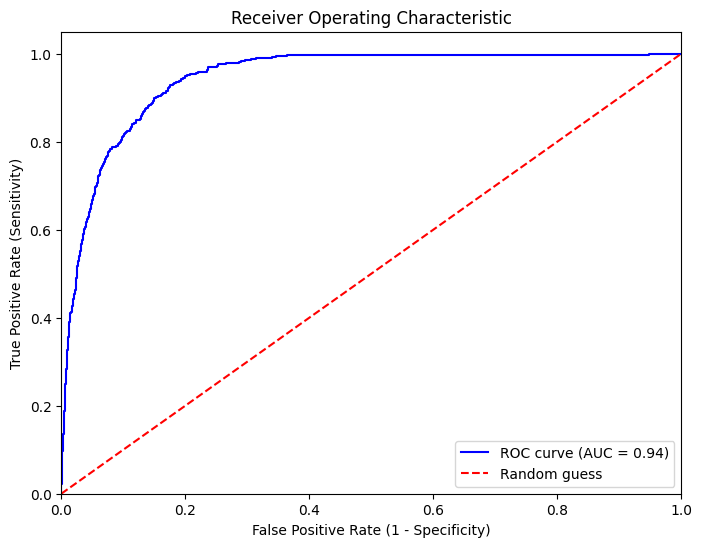

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the test data
y_pred_prob = model.predict(X_test)

# Compute fpr, tpr, and thresholds using the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# evaluate the model on test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/50
2413/2413 [==============================] - 7s 3ms/step - loss: 0.0851 - accuracy: 0.9799 - val_loss: 0.0776 - val_accuracy: 0.9801
Epoch 2/50
2413/2413 [==============================] - 6s 2ms/step - loss: 0.0759 - accuracy: 0.9803 - val_loss: 0.0743 - val_accuracy: 0.9803
Epoch 3/50
2413/2413 [==============================] - 6s 3ms/step - loss: 0.0738 - accuracy: 0.9802 - val_loss: 0.0717 - val_accuracy: 0.9803
Epoch 4/50
2413/2413 [==============================] - 5s 2ms/step - loss: 0.0722 - accuracy: 0.9803 - val_loss: 0.0699 - val_accuracy: 0.9803
Epoch 5/50
2413/2413 [==============================] - 6s 2ms/step - loss: 0.0708 - accuracy: 0.9804 - val_loss: 0.0688 - val_accuracy: 0.9803
Epoch 6/50
2413/2413 [==============================] - 6s 3ms/step - loss: 0.0695 - accuracy: 0.9804 - val_loss: 0.0690 - val_accuracy: 0.9803
Epoch 7/50
2413/2413 [==============================] - 6s 2ms/step - loss: 0.0685 - accuracy: 0.9804 - val_loss: 0.0702 - val_accuracy:

In [ ]:
# Evaluate model 

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


754/754 [==============================] - 1s 2ms/step - loss: 0.0612 - accuracy: 0.9809
Test loss: 0.06115990877151489
Test accuracy: 0.9808505177497864


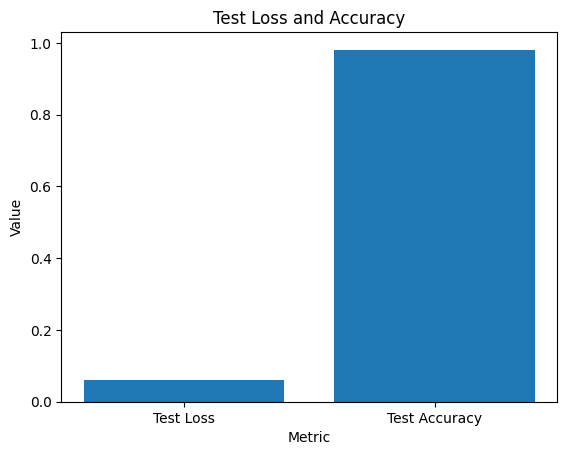

In [ ]:
import matplotlib.pyplot as plt

# Set the values for test loss and accuracy
test_loss = 0.06115990877151489
test_accuracy = 0.9808505177497864

# Create a bar plot
values = [test_loss, test_accuracy]
labels = ['Test Loss', 'Test Accuracy']
plt.bar(labels, values)

# Add labels and title to the plot
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Test Loss and Accuracy')

# Display the plot
plt.show()


In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


In [ ]:
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=10, verbose_eval=10)


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0522549	valid_1's binary_logloss: 0.0577202
[20]	training's binary_logloss: 0.0435978	valid_1's binary_logloss: 0.0511724
[30]	training's binary_logloss: 0.0379828	valid_1's binary_logloss: 0.0471144
[40]	training's binary_logloss: 0.0343247	valid_1's binary_logloss: 0.0447874
[50]	training's binary_logloss: 0.0318081	valid_1's binary_logloss: 0.0436438
[60]	training's binary_logloss: 0.0298529	valid_1's binary_logloss: 0.0429114
[70]	training's binary_logloss: 0.0281879	valid_1's binary_logloss: 0.0424507
[80]	training's binary_logloss: 0.0269469	valid_1's binary_logloss: 0.0422419
[90]	training's binary_logloss: 0.0257164	valid_1's binary_logloss: 0.0420936
[100]	tr

In [ ]:
# Load the test data
#test_data = pd.read_csv('test_data.csv')

# Convert categorical features to integer codes
#df["isrc_home_country"] = df["isrc_home_country"].astype('category').cat.codes
#test_data["frontline_catalogue"] = test_data["frontline_catalogue"].astype('category').cat.codes
#test_data["sub_genre_name"] = test_data["sub_genre_name"].astype('category').cat.codes

# Select the same features as in the training data
test_features = df[feature_cols]

for i in range(len(test_features)):
    test_prediction = bst.predict(test_features.iloc[[i]], num_iteration=bst.best_iteration)[0]
    if test_prediction > 0.5:
        test_predictions.append(1)
    else:
        test_predictions.append(0)

# Print the binary predictions
print(test_predictions)


[0.04195629424512334, 0.706579920676567, 0.00012461893025766336, 0.0003969430657801545, 0.00030629743931239085, 0.00013795766818990683, 0.00027907966647532204, 0.00019999733482124204, 0.0002891828577300059, 0.019330963319584008, 0.0003956946568753882, 0.0003940796220793635, 0.0003734596677082879, 0.029084236379911813, 0.00028154179564711905, 0.00032771043701866447, 0.00048814274992302337, 0.00022281334830490088, 0.00027167015952487997, 0.0002854517039420167, 0.00032285338759977796, 0.0003617432687134767, 0.00017559362513795552, 0.0004145979985336258, 0.00012602234031188384, 0.0002523397403551801, 0.026863906548261034, 0.0022360775761293295, 0.52676876405023, 0.0003407758115137185, 0.01337357651388791, 0.051003665343685126, 0.036775017296305175, 0.016768233485884024, 0.10530078778035996, 0.13704566699939053, 0.1268711653323364, 0.04798367458469299, 0.32356990667902613, 0.006545853284093138, 0.004844857579919762, 0.044907677339328836, 0.5558603336480373, 0.0003967648063768185, 0.00105997

In [ ]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'verbose': 1
}

num_round = 1000
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=10, verbose_eval=10)


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1157, number of negative: 57951
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 59108, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019574 -> initscore=-3.913767
[LightGBM] [Info] Start training from score -3.913767
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.982323	valid_1's auc: 0.969152
[20]	training's auc: 0.98694	valid_1's auc: 0.971454
[30]	training's auc: 0.990174	valid_1's auc: 0.972354
[40]	training's auc: 0.992305	valid_1's auc: 0.973043
[50]	training's auc: 0.993792	valid_1's auc: 0.973304
[60]	training's auc: 0.994844	valid_1's auc: 0.973683
[70]	training's auc: 0.995777	valid_1's auc: 0.973836
[80]	training's auc: 0.996767	valid_1's auc: 0.973968
[90]	trainin

In [ ]:
new_data = {'total_streams_ratio': 0.5, 
            'saves_per_stream': 0.1, 
            'spotify_editorial_streams_ratio': 0.2, 
            'spotify_streams_percentage': 0.4, 
            'tiktok_streams_percentage': 0.1, 
            'tiktok_creations_percentage': 0.05, 
            'youtube_streams_percentage': 0.15, 
            'amazon_streams_percentage': 0.05, 
            'apple_streams_percentage': 0.1, 
            'home_country_stream_ratio': 0.6}

new_df = pd.DataFrame(data=new_data, index=[0])

prediction = bst.predict(new_df, num_iteration=bst.best_iteration)[0]
if prediction > 0.5:
    print("This track is likely to become a global hit.")
else:
    print("This track is unlikely to become a global hit.")


This track is unlikely to become a global hit.


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search
params = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_data_in_leaf': [10, 20, 30],
    'feature_fraction': [0.5, 0.7, 0.9]
}

# Create the LightGBM model
model = lgb.LGBMClassifier()

# Perform the grid search
grid = GridSearchCV(model, params, verbose=1, cv=3)
grid.fit(X_train, y_train)

# Print the best set of hyperparameters
print(grid.best_params_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will 